In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
from PIL import Image
x_train = np.load('/content/drive/MyDrive/HW11/train_x.npy')
x_train = (x_train - 127.5 ) / 127.5

In [ ]:
# Build generator, the targeted image size is the same with the training data (96, 96, 3)
input_size = 100 # Input vector size
m = 100 # number of images trained in each iteration

generator = tf.keras.Sequential([tf.keras.Input(shape=(input_size)),
                                 tf.keras.layers.Dense(24*24*256, use_bias=False),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.LeakyReLU(),

                                 tf.keras.layers.Reshape(target_shape=(24, 24, 256)),

                                 tf.keras.layers.Conv2DTranspose(128, 5, strides=1, padding='same', use_bias=False),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.LeakyReLU(),

                                 tf.keras.layers.Conv2DTranspose(64, 5, strides=2, padding='same', use_bias=False),
                                 tf.keras.layers.BatchNormalization(),
                                 tf.keras.layers.LeakyReLU(),

                                 tf.keras.layers.Conv2DTranspose(3, 5, strides=2, padding='same', use_bias=False)])

In [ ]:
# Build discriminator
discriminator = tf.keras.Sequential([tf.keras.layers.Input(shape=(96, 96, 3)),
                                     tf.keras.layers.Conv2D(64, 5, strides=2, padding='same', use_bias=False),
                                     tf.keras.layers.LeakyReLU(),
                                     tf.keras.layers.Dropout(0.3),

                         tf.keras.layers.Conv2D(128, 5, strides=2, padding='same', use_bias=False),
                         tf.keras.layers.LeakyReLU(),
                         tf.keras.layers.Dropout(0.3),
                         
                         tf.keras.layers.Flatten(),
                         tf.keras.layers.Dense(1)                
])

In [ ]:
# def losses for discriminator training and generator training
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def generator_loss(y_true, generator_output):
  fake_output = discriminator(generator_output, training=True)
  loss = cross_entropy(y_true, fake_output)
  return loss

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

discriminator.compile(optimizer=discriminator_optimizer, loss=tf.losses.BinaryCrossentropy(from_logits=True))
generator.compile(optimizer=generator_optimizer, loss=generator_loss)

In [ ]:
print(tf.shape(tf.concat((tf.ones(shape=(m, )), tf.zeros(shape=(m, ))), axis=0)))

tf.Tensor([200], shape=(1,), dtype=int32)


In [ ]:
epochs = 50
input_image_size = (m, 96, 96, 3)

for i in range(epochs):
  print("Current epoch is:"+str(i))
  for j in range(100):
    real_images = x_train[j*100:j*100+100, :, :, :]

    g_inputs = tf.random.normal([m, input_size])
    g_images = generator(g_inputs, training=True)

    d_train_x = tf.concat((real_images, g_images), axis=0)
    d_train_y = tf.concat((tf.ones(shape=(m, )), tf.zeros(shape=(m, ))), axis=0)

    # Train discriminator
    # generator.trainable = False
    # discriminator.trainable = True
    discriminator.fit(d_train_x, d_train_y, epochs=1, verbose=0)

    # Trian generator
    # generator.trainable = True
    # discriminator.trainable = False
    g_train_x = np.random.rand(m, input_size)
    g_train_y = tf.ones(shape=(m, ))
    generator.fit(g_train_x, g_train_y, epochs=1, verbose=0)

Current epoch is:0
Current epoch is:1
Current epoch is:2
Current epoch is:3
Current epoch is:4
Current epoch is:5
Current epoch is:6
Current epoch is:7
Current epoch is:8
Current epoch is:9
Current epoch is:10
Current epoch is:11
Current epoch is:12
Current epoch is:13
Current epoch is:14
Current epoch is:15
Current epoch is:16
Current epoch is:17
Current epoch is:18
Current epoch is:19
Current epoch is:20
Current epoch is:21
Current epoch is:22
Current epoch is:23
Current epoch is:24
Current epoch is:25
Current epoch is:26
Current epoch is:27
Current epoch is:28
Current epoch is:29
Current epoch is:30
Current epoch is:31
Current epoch is:32
Current epoch is:33
Current epoch is:34
Current epoch is:35
Current epoch is:36
Current epoch is:37
Current epoch is:38
Current epoch is:39
Current epoch is:40
Current epoch is:41
Current epoch is:42
Current epoch is:43
Current epoch is:44
Current epoch is:45
Current epoch is:46
Current epoch is:47
Current epoch is:48
Current epoch is:49


tf.Tensor(
[[-0.66253495]
 [-0.85477424]
 [-1.2970004 ]
 [ 0.26958793]
 [-0.8630219 ]
 [ 0.5707757 ]], shape=(6, 1), dtype=float32)


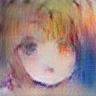

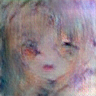

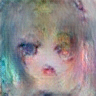

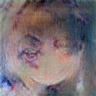

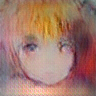

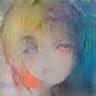

In [8]:
# use trained generator to generate images
g_inputs = tf.random.normal([6, input_size])
print(discriminator(generator(g_inputs)))
generated_images = tf.cast(generator.predict(g_inputs) * 127.5 + 127.5, dtype='int64')
generated_images = tf.clip_by_value(generated_images, clip_value_min=0, clip_value_max=255)

for i in range(6):
  img = tf.keras.preprocessing.image.array_to_img(generated_images[i, :, :, :])
  display(img)